In [8]:
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt
import random
import os

In [9]:
print(os.getcwd())

/gpfs/ysm/home/of56/MGH


In [14]:
#Data import
cytokines = pd.read_csv("/gpfs/ysm/home/of56/MGH/data/allcytokinesmerged_20200730_ANON.csv")
patient_data = pd.read_csv("/gpfs/ysm/home/of56/MGH/data/CAE_data_04092021_ANON.csv")
biomarker_orig = pd.read_csv("/gpfs/ysm/home/of56/MGH/data/CAE_TnT_original_data.csv") #contains all time points


#print shapes of data
print(cytokines.shape)
print(patient_data.shape)
print(biomarker_orig.shape)

#merge biomarker and patient data
#patient_data.merge(biomarker,left_on='ID', right_on= 'ID')


(1500, 116)
(225, 149)
(842, 7)


In [5]:
#sort cytokine by ID 
ind = cytokines.iloc[:,0].isnull().to_numpy() #Get indices of numpy array that are nonempty
valID = np.unique(cytokines.iloc[~ind,0].to_numpy()) #Get unique ID's of patients

#For each unique patient ID, append features to form single row of features for unique patients
newcytokinedata =  [] # intialize new cytokine data list 
for i in valID: #select a new unique ID
    
    helper = []
    for j in range(cytokines.iloc[:,0].shape[0]): # check all other rows to see if they have a unique ID
        if i == cytokines.iloc[j,0]:
            helper.append(cytokines.iloc[j,:].to_numpy())
           
    newcytokinedata.append(np.array(helper).flatten()) # create new pandas array
    
processed_cytokine = pd.DataFrame(newcytokinedata)


#Get number of ID repeats
numbrepeats = int(processed_cytokine.columns.values.shape[0]/cytokines.shape[1]) 
    
ncolnames = []
for i in range(numbrepeats):
    ncolnames.append(cytokines.columns.values + "_"+str(i))
    
flatlist = [item for sublist in ncolnames for item in sublist]    
processed_cytokine.columns = flatlist





NameError: name 'cytokines' is not defined

In [5]:

#sort biomarker original data
valID = np.unique(biomarker_orig.iloc[:,4])
newtroponin = []
for i in valID:
    
    helper = []
    for j in range(len(biomarker_orig.iloc[:,4])):
        if i == biomarker_orig.iloc[j,4]:
            helper.append(biomarker_orig.iloc[j,:].to_numpy())
            
    newtroponin.append(np.array(helper).flatten())
    
processed_troponin = pd.DataFrame(newtroponin)


#Redefine new columnames
ncolnames = []
for i in range(9):
    ncolnames.append(biomarker_orig.columns.values + "_" + str(i))
flatlist = [item for sublist in ncolnames for item in sublist]

processed_troponin.columns = flatlist



In [9]:
# Combine troponin and cytokine data with patient data

print(patient_data.shape)
print(processed_cytokine.shape)
print(processed_troponin.shape)

print(processed_troponin.iloc[:,4]) #column with patient ID
print(processed_cytokine.iloc[:,0]) #column with patient ID
print(patient_data["ID"]) #column with patient ID


#Append rows by patient ID
IDlist = [x.replace(" ","") for x in patient_data["ID"].values]
a = 0
c = 0
newlist = []
for i in range(len(IDlist)):
 
    helper = []
    helper.append(patient_data.iloc[i,:].values.flatten().tolist()) #append patient data
    
    for j in range(len(processed_troponin.iloc[:,4])): #append troponin data
        if processed_troponin.iloc[j,4].replace(" ","") == IDlist[i]:
            helper.append(processed_troponin.iloc[j,:].values.flatten().tolist())

            a = a + 1
            
    #if patient has no troponin data, put negative ones           
    if len(helper) < 2 :
        helper.append(list(np.ones(63)*-1)) #length of list known a priori
     

    for k in range(len(processed_cytokine.iloc[:,0])): #append cytokine data
        if processed_cytokine.iloc[k,0].replace(" ","") == IDlist[i]:
            helper.append(processed_cytokine.iloc[k,:].values.flatten().tolist())
            
            c = c + 1
         
    #if patient has no cytokine data, put negative ones
    if len(helper) < 3:
        helper.append(list(np.ones(1044)*-1)) 
                      
    flat_list = [item for sublist in helper for item in sublist]
    newlist.append(flat_list)
    
    
newdf = pd.DataFrame(newlist)


#Combine list of column names for all datasets
templist = list(patient_data.columns.values) + list(processed_troponin.columns.values) + list(processed_cytokine.columns.values)

#Set list of colum names for all datasets
newdf.columns = templist




(225, 149)
(202, 1044)
(200, 63)
0      02-1-01ZL1 001
1      02-1-01ZL1 002
2      02-1-01ZL1 003
3      02-1-01ZL1 004
4      02-1-01ZL1 005
            ...      
195    02-1-01ZL1 272
196    02-1-01ZL1 273
197    02-1-04ZL1-005
198    02-1-04ZL1-007
199    02-1-04ZL1-009
Name: Study ID P01_0, Length: 200, dtype: object
0       02-1-01ZL1001
1       02-1-01ZL1002
2       02-1-01ZL1003
3       02-1-01ZL1004
4       02-1-01ZL1005
            ...      
197     02-1-01ZL1272
198     02-1-01ZL1273
199    02-1-04ZL1-005
200    02-1-04ZL1-007
201    02-1-04ZL1-009
Name: id_PO1_0, Length: 202, dtype: object
0      01-1-01ZL1 007
1      02-1-01ZL1 093
2      02-1-01ZL1 217
3      02-1-01ZL1 053
4      02-1-01ZL1 014
            ...      
220    02-1-01ZL1 264
221    02-1-04ZL1-009
222    02-1-01ZL1 272
223    02-1-01ZL1 274
224    02-1-01ZL1 271
Name: ID, Length: 225, dtype: object


In [10]:
# Step 1 filtering for redundant/irrelevant variables variables


#Can I create something general to clean data?
#example of how to convert dates to continuous time
#time =  pd.to_datetime(patient_data['TreatmentEndDate'].values) - pd.to_datetime(patient_data['TreatmentStartDate'].values) #convert into time difference
#timediff = time/np.timedelta64(1,'D') #convert to integer format
#patient_data['TreatmentTime'] = timediff

#Convert all dates into times


#Step 1: Get all columns with the word 'date/Date' 


dateindex = []
for i in range(len(newdf.columns)):
    if 'date' in newdf.columns[i] or 'Date' in newdf.columns[i] or 'start' in newdf.columns[i]  or 'end' in newdf.columns[i] and newdf.columns[i] != 'Gender' and  newdf.columns[i] != 'gender0':
        dateindex.append(i)
print(newdf.columns[dateindex])

#Step 2: Convert dates to time (NOTE: all times are in dates)


newdf['TreatmentTime'] =( ( pd.to_datetime(newdf['TreatmentEndDate'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['TreatmentEnd_to_lastcontact'] =( ( pd.to_datetime(newdf['Last_Contact_Date'].values) - pd.to_datetime(newdf['TreatmentEndDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['Time_to_CAE'] =( ( pd.to_datetime(newdf['CAE_startdate'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['pretrt_bloodtest'] =( ( pd.to_datetime(newdf['TreatmentStartDate'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['blood_test_1'] =( ( pd.to_datetime(newdf['Blood drawn date_1'].values) - pd.to_datetime(newdf['Blood drawn date_0'].values) ) /np.timedelta64(1,'D') ).values
newdf['blood_test_2'] =( ( pd.to_datetime(newdf['Blood drawn date_2'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['blood_test_3'] =( ( pd.to_datetime(newdf['Blood drawn date_3'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['blood_test_4'] =( ( pd.to_datetime(newdf['Blood drawn date_4'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['blood_test_5'] =( ( pd.to_datetime(newdf['Blood drawn date_5'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['blood_test_6'] =( ( pd.to_datetime(newdf['Blood drawn date_6'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['blood_test_7'] =( ( pd.to_datetime(newdf['Blood drawn date_7'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['blood_test_8'] =( ( pd.to_datetime(newdf['Blood drawn date_8'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values

newdf['pretrt_cytokinetest'] =( ( pd.to_datetime(newdf['TreatmentStartDate'].values) - pd.to_datetime(newdf['testdate_0'].values) ) /np.timedelta64(1,'D') ).values
newdf['cytokine_test_1'] =( ( pd.to_datetime(newdf['testdate_1'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['cytokine_test_2'] =( ( pd.to_datetime(newdf['testdate_2'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['cytokine_test_3'] =( ( pd.to_datetime(newdf['testdate_3'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['cytokine_test_4'] =( ( pd.to_datetime(newdf['testdate_4'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['cytokine_test_5'] =( ( pd.to_datetime(newdf['testdate_5'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['cytokine_test_6'] =( ( pd.to_datetime(newdf['testdate_6'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['cytokine_test_7'] =( ( pd.to_datetime(newdf['testdate_7'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values
newdf['cytokine_test_8'] =( ( pd.to_datetime(newdf['testdate_8'].values) - pd.to_datetime(newdf['TreatmentStartDate'].values) ) /np.timedelta64(1,'D') ).values


#NOTE: time period for troponing is the same for different blood samples
newdf['troponin_test'] =( ( pd.to_datetime(newdf['tmtend_0'].values) - pd.to_datetime(newdf['tmtstart_0'].values) ) /np.timedelta64(1,'D') ).values


#Step 3 Drop redundant or unnecessary columns


newdf = newdf.drop(columns = newdf.columns[dateindex].values) #Drop all dates
redundant = []
for i in range(len(newdf.columns)):
    if 'Sample' in newdf.columns[i] or 'Study' in newdf.columns[i]:
        redundant.append(i)
newdf = newdf.drop(columns = newdf.columns[redundant].values) #Drop redundant values
newdf = newdf.fillna(-1) #fill nan's with negative 1's
newdf.to_csv("./processed_data/newdf.csv")
        

#Postprocess/clean columns with erroneous values (known a posteriori)



Index(['TreatmentStartDate', 'TreatmentEndDate', 'Last_Contact_Date',
       'CAE_startdate', 'Blood drawn date_0', 'tmtstart_0', 'tmtend_0',
       'Blood drawn date_1', 'tmtstart_1', 'tmtend_1', 'Blood drawn date_2',
       'tmtstart_2', 'tmtend_2', 'Blood drawn date_3', 'tmtstart_3',
       'tmtend_3', 'Blood drawn date_4', 'tmtstart_4', 'tmtend_4',
       'Blood drawn date_5', 'tmtstart_5', 'tmtend_5', 'Blood drawn date_6',
       'tmtstart_6', 'tmtend_6', 'Blood drawn date_7', 'tmtstart_7',
       'tmtend_7', 'Blood drawn date_8', 'tmtstart_8', 'tmtend_8',
       'testdate_0', 'testdate_1', 'testdate_2', 'testdate_3', 'testdate_4',
       'testdate_5', 'testdate_6', 'testdate_7', 'testdate_8'],
      dtype='object')


In [11]:
#Step 4 split between features and targets

targets = newdf.iloc[:,2:8]
targets.to_csv("./processed_data/targets.csv")
features = newdf.drop(columns = newdf.columns[2:8].values)
features.to_csv("./processed_data/features.csv")

#Step 5 sort categorical and continuous features (features)

#look for columns with strings
stringcat = []
for i in range(len(features.columns.values)): #loop through each column
    for j in range(len(features.iloc[:,0])): #loop through each row
        
        if isinstance(features.iloc[j,i],str) == True:
            stringcat.append(i) #If any of the elements in row contains string, store column and go to next column
            break
            
#find categorical variables that are not strings

#os_status, preHD, Race, Karnofsky, type, gender0, race0, hist, stage, kps, smoke
nonstringcat = [3, 7, 10, 11, 40, 41, 42, 43, 44 ,48]
catindex = stringcat + nonstringcat #store all categorical indices


#Get indices for continuous variables
tcontindex = list(np.arange(features.shape[1]))
contindex = [i for i in tcontindex if i not in catindex]




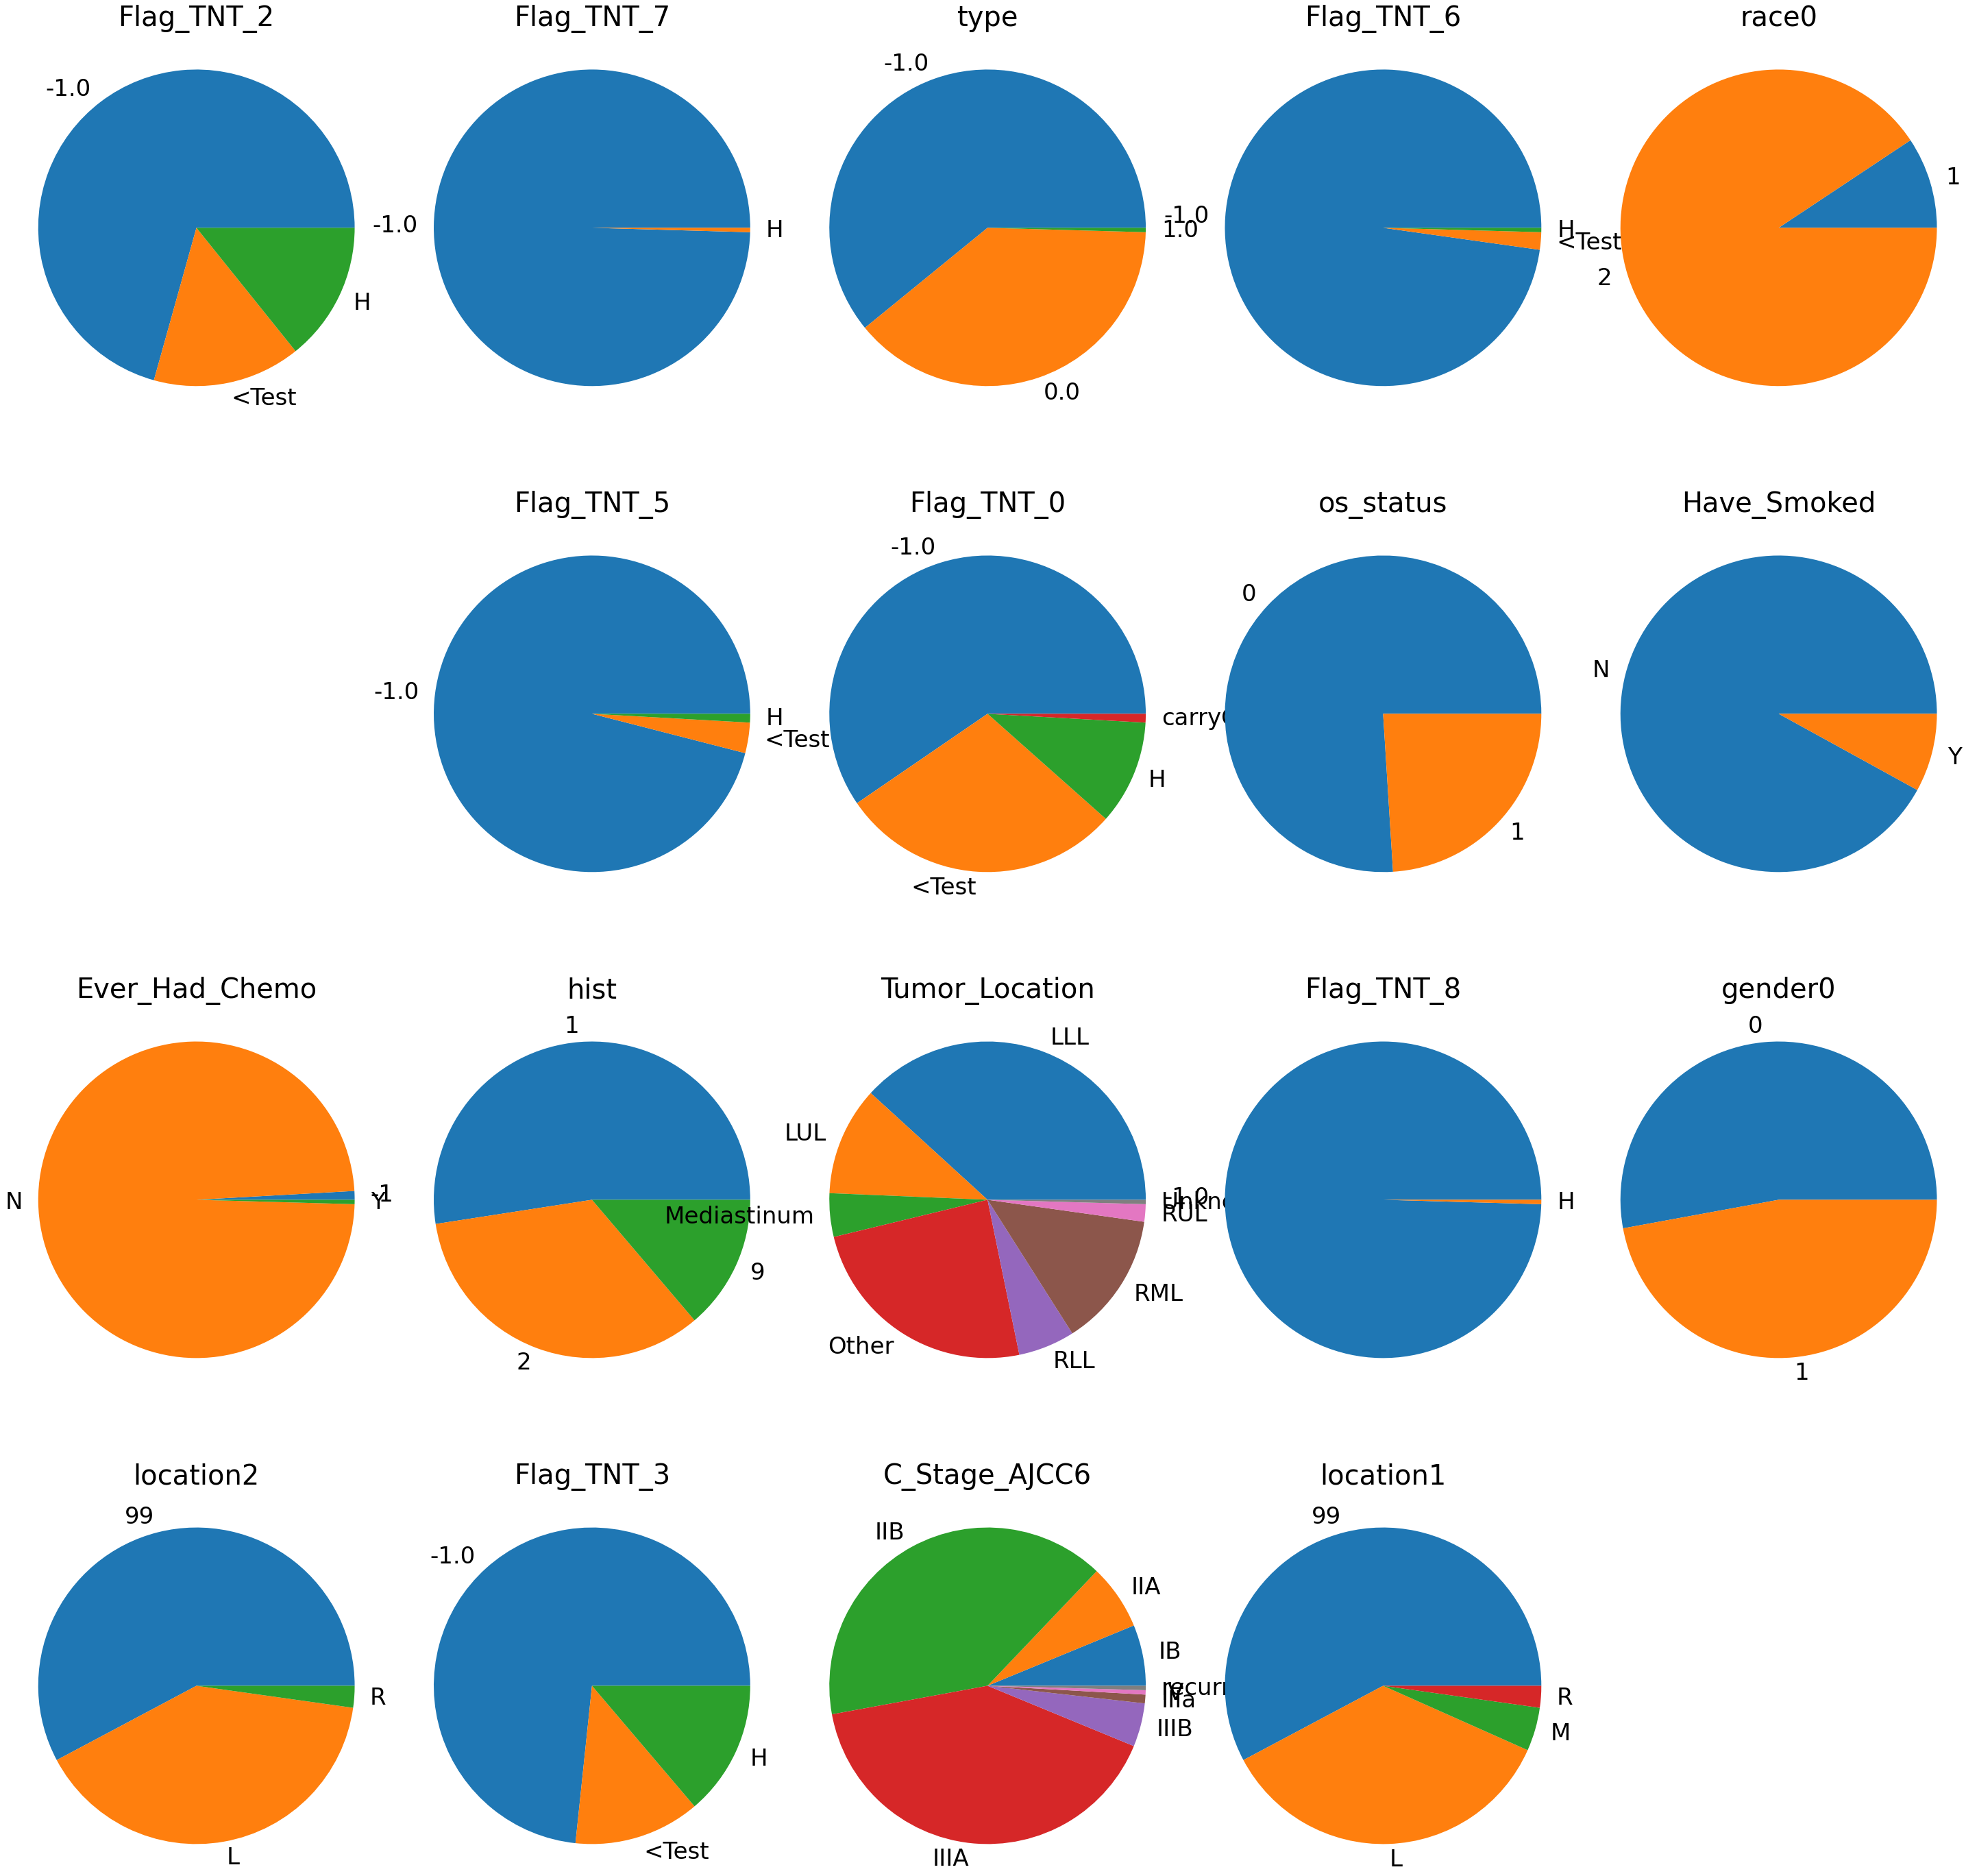

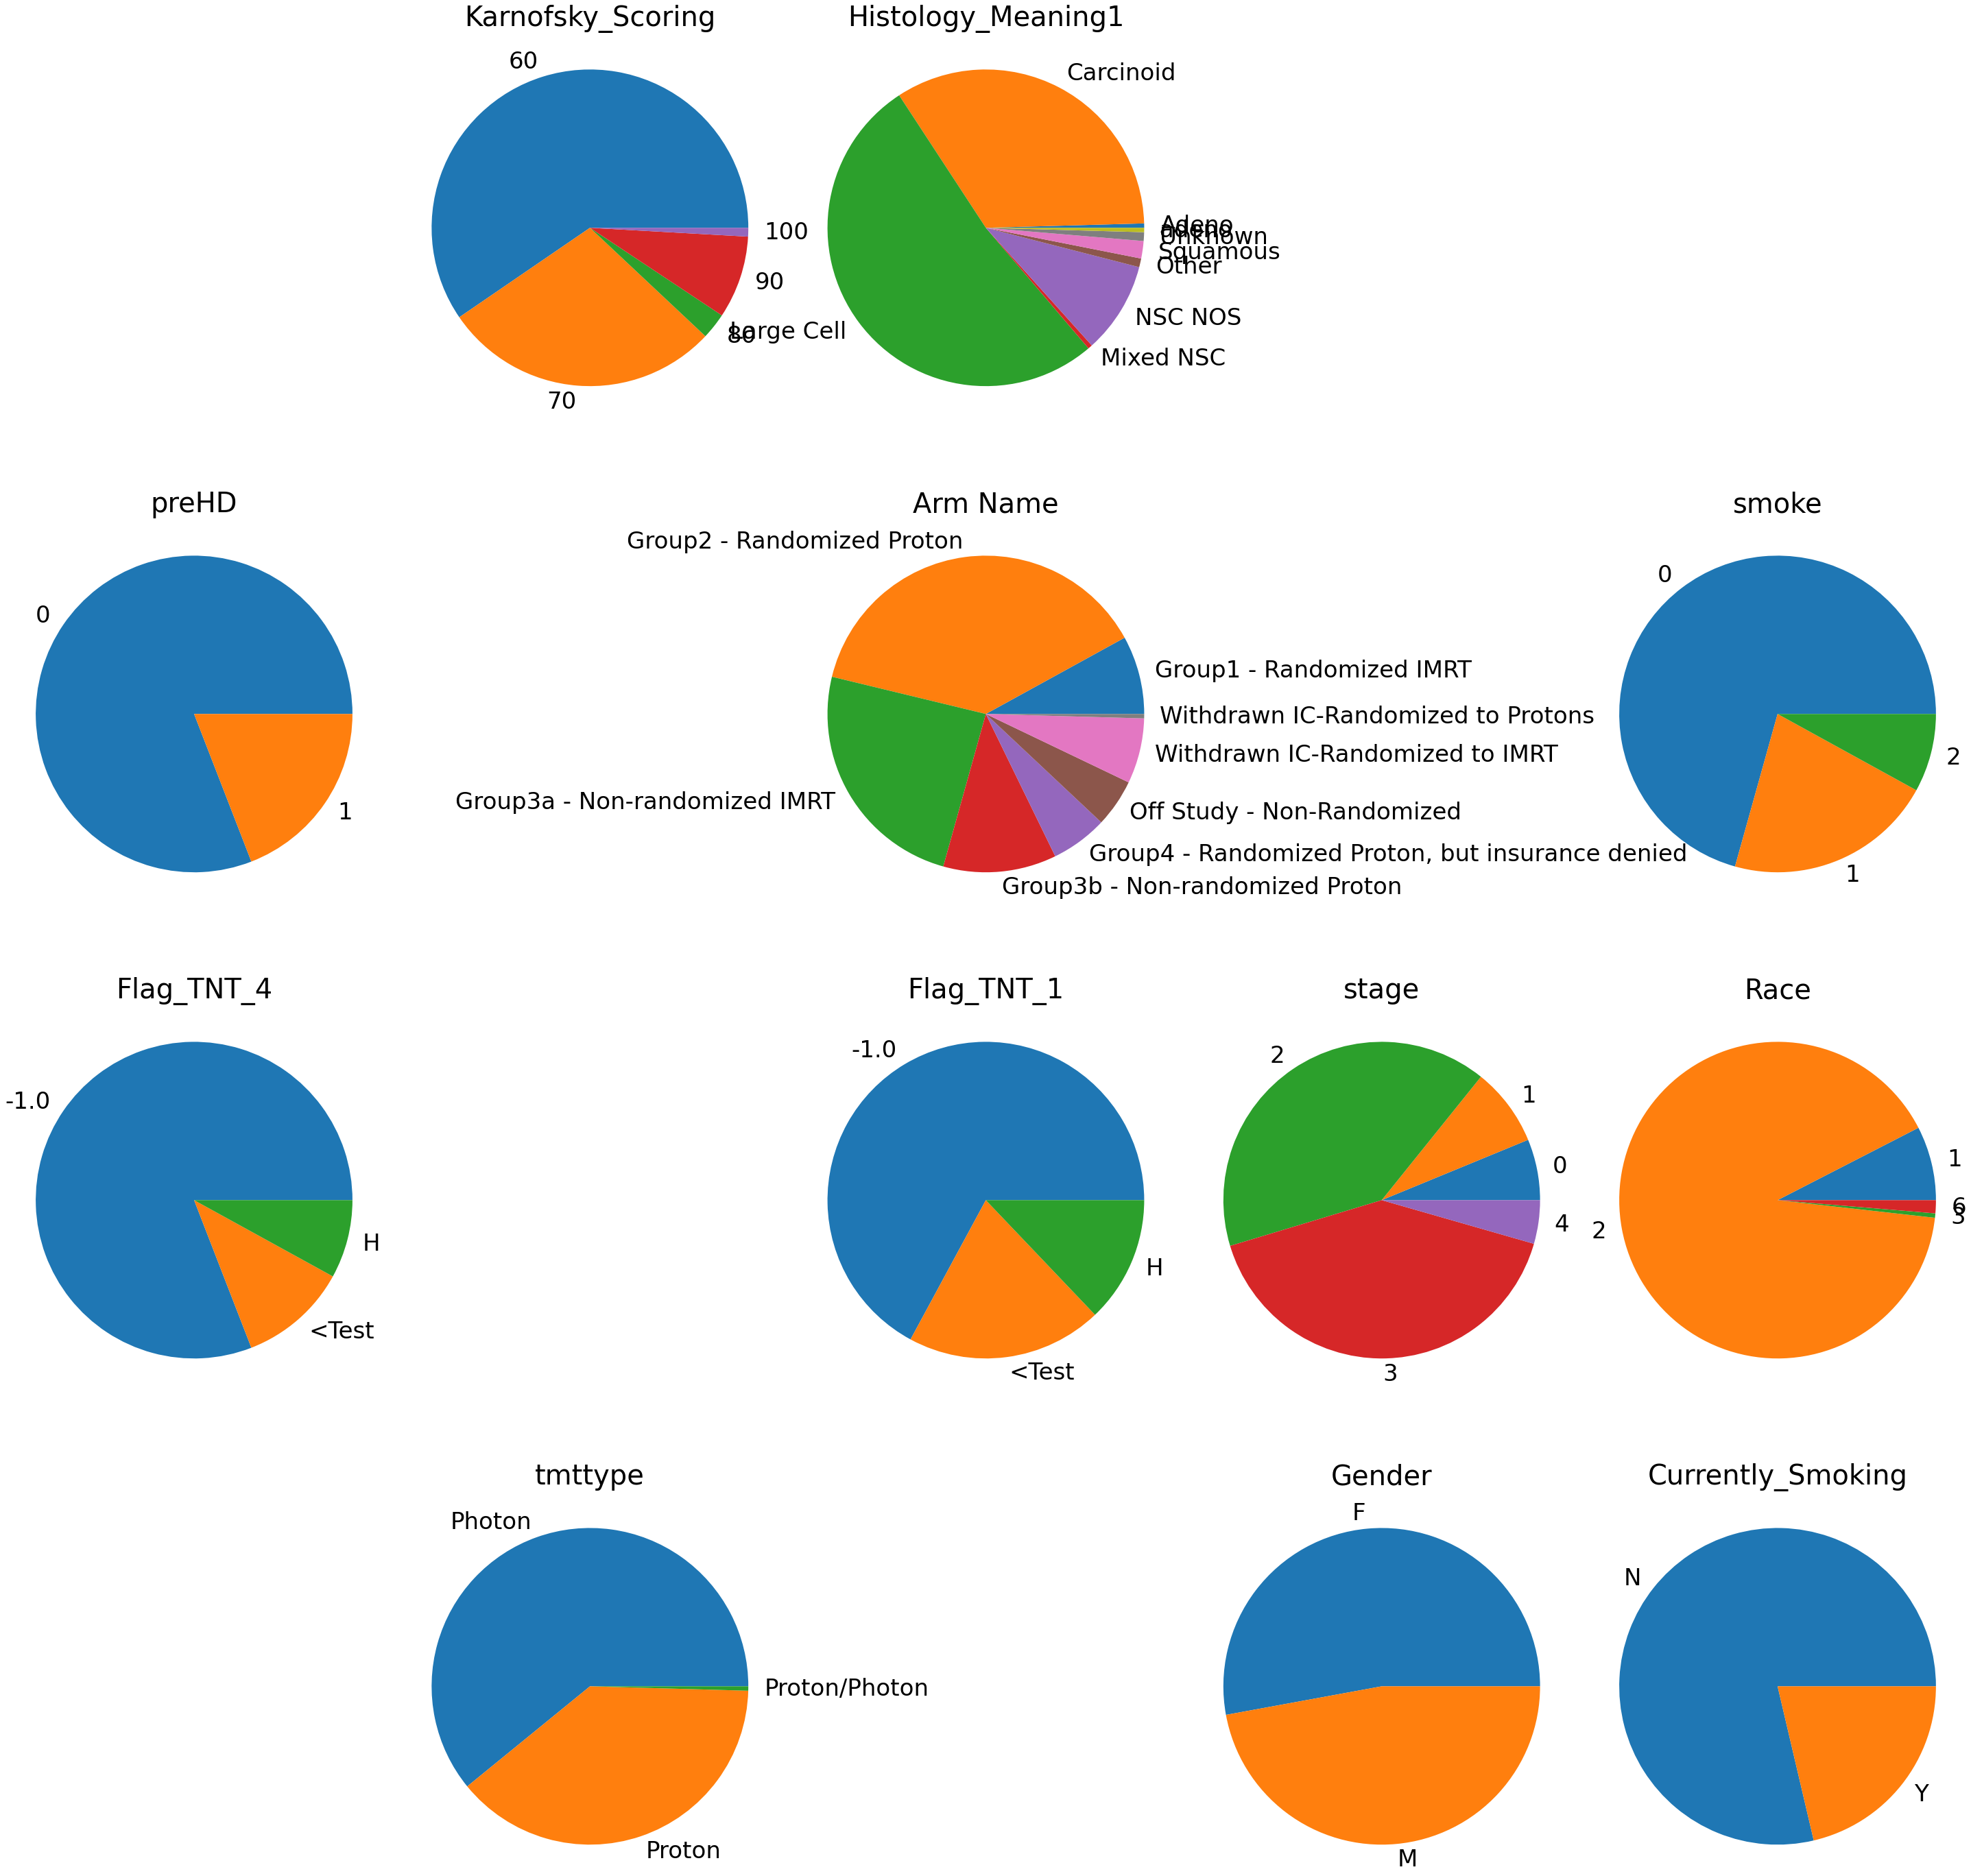

In [295]:
#Step 5 Convert categorical to numbered categorical and get statistics

#Printing statistics on patient data (categorical)
plotdicts = []
xv = []
for k in range(len(catindex)):
    
    x = pd.get_dummies(features.iloc[:,catindex[k]])
    xv.append(x)
    a = 0
    for i in range(x.shape[1]): #Go through each possible category of categorical variable (go through columns)
        a = a + 1
        for j in range(x.shape[0]): #Go through rows and add 1 to each instnace of cateogry to make categories unique (heuristic)
            if x.iloc[j,i] == 1:
                x.iloc[j,i] = x.iloc[j,i] + a


    for i in range(x.shape[0]): #Sum across each row (each row should have a value in one column and zero elsewhere)
        features.iloc[i,catindex[k]] = x.iloc[i,:].sum() #define new column in features dataframe

    
    #store dictionaries for plotting pie charts
    my_dict = {i:list(features.iloc[:,catindex[k]].values).count(i) for i in list(features.iloc[:,catindex[k]].values)} #create dictionary 
    plotdicts.append(my_dict)
    
    
#Plotting pie charts of categorical variables
shfcat = list(np.arange(len(catindex)))
random.shuffle(shfcat)

plt.figure(figsize=(50,50))
for i in range(20):
    if "id" in features.columns[catindex[shfcat[i]]] or "ID" in features.columns[catindex[shfcat[i]]]:
        continue
    plt.subplot(4,5,i+1)
    plt.title(features.columns[catindex[shfcat[i]]],fontsize=40,y=1.1)
    plt.pie(list(plotdicts[shfcat[i]].values()),labels = xv[shfcat[i]].columns, radius = 1.2,textprops= {"fontsize":34} )
    plt.savefig("./processed_data/catpie_1.png")

plt.figure(figsize=(50,50))
j = i
for i in range(20):
    j = j + 1
    if "id" in features.columns[catindex[shfcat[j]]] or "ID" in features.columns[catindex[shfcat[j]]]:
        continue
    plt.subplot(4,5,i+1)
    plt.title(features.columns[catindex[shfcat[j]]],fontsize=40,y=1.1)
    plt.pie(list(plotdicts[shfcat[j]].values()),labels = xv[shfcat[j]].columns, radius = 1.2,textprops= {"fontsize":34} )
    plt.savefig("./processed_data/catpie_2.png")



In [296]:
#Printing statistics on patient data (continuous)

#Get means/standard deviations of continuous data
stdv = []
avg = []
for i in range(len(contindex)):
    avg.append(np.mean(features.iloc[:,contindex[i]]))
    stdv.append(np.std(features.iloc[:,contindex[i]]))
    
contstat = {} #dictionary of means/standard deviations
for i in range(len(contindex)):
    contstat[i] = {features.columns[contindex[i]]:[avg[0],stdv[0]]}
    
#Create pandas data frame of means/standard deviations

avgstdcont = np.concatenate( (np.array(avg).reshape(len(avg),1),np.array(stdv).reshape(len(stdv),1)), axis=1)
dfavgstd = pd.DataFrame(avgstdcont)
dfavgstd["column_names"] = features.columns[contindex]
dfavgstd.to_csv("./processed_data/avgstdcont.csv")

In [178]:
#Step 6: Sort target data




{'os_time1': [33.43496296311111, 25.406060953379136]}